## This notebook compares and visualizes the results of 2 models.

In [2]:
# Import

In [1]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import time
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
from sklearn.decomposition import PCA
import pandas as pd

from pandas.core import base
from utils import *  # bad practice, nvm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import NumpyDataset, TransformerEnsembleDataset, TrainSamplerMultiClass, TrainSampler, TrainSamplerMultiClassUnit
from models import AggregateFeatEnsemble, DynamicWeightEnsemble, LogisticRegression, BertClassiferHyperparams, SimpleEnsemble, FixedWeightEnsemble
from tqdm import tqdm
import time
import torch.nn.functional as F
from contrastive_utils import compute_sim_matrix, compute_target_matrix, contrastive_loss

ckpt_dir = 'exp_data'

[nltk_data] Downloading package stopwords to /home/aibo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aibo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# specify ids of the 2 models
model1 = "6b"
model2 = "6A" # basline model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Load features of the 2 models

In [6]:
output_list_1 = torch.load("./exp_data/output_list_" + model1 + ".pt").cpu().numpy() 
feature_list_1 = torch.load("./exp_data/feature_list_" + model1 + ".pt").cpu().numpy()
label_list_1 = torch.load("./exp_data/label_list_" + model1 + ".pt")
output_list_2 = torch.load("./exp_data/output_list_" + model2 + ".pt").cpu().numpy()
feature_list_2 = torch.load("./exp_data/feature_list_" + model2 + ".pt").cpu().numpy()
label_list_2 = torch.load("./exp_data/label_list_" + model2 + ".pt")

truth_list_1 = []
truth_list_2 = []
for l1, l2 in zip(label_list_1, label_list_2):
    l1 = l1.cpu().numpy().astype(np.int32)
    l2 = l2.cpu().numpy().astype(np.int32)
    truth_list_1 = np.concatenate((truth_list_1, l1))
    truth_list_2 = np.concatenate((truth_list_2, l2))
truth_label_1 = truth_list_1.astype(np.int64)
truth_label_2 = truth_list_2.astype(np.int64)
pred_label_1 = np.argmax(output_list_1, axis=1)
pred_label_2 = np.argmax(output_list_2, axis=1)

In [7]:
print(len(truth_label_1))
print(len(truth_label_2))

12384
12384


### Class-Wise Accuracy

In [13]:
n_classes = 62
class_acc_dic = {} # for each class's samples, how many are correctly predicted and how many are falsely predicted
for c in range(n_classes):
    class_acc_dic[c] = {}
    class_acc_dic[c][model1] = {}
    class_acc_dic[c][model2] = {}
    class_acc_dic[c][model1]["T"] = 0
    class_acc_dic[c][model1]["F"] = 0
    class_acc_dic[c][model2]["T"] = 0
    class_acc_dic[c][model2]["F"] = 0
for (tl1, pl1, tl2, pl2) in zip(truth_label_1, pred_label_1, truth_label_2, pred_label_2):
    if tl1 == pl1:
        class_acc_dic[tl1][model1]["T"] += 1
    else:
        class_acc_dic[tl1][model1]["F"] += 1
    if tl2 == pl2:
        class_acc_dic[tl2][model2]["T"] += 1
    else:
        class_acc_dic[tl2][model2]["F"] += 1
acc_imp = {}
failed_class = []
X = []
acc1_list = []
acc2_list = []
size_list = []
total_size = 0
print("======================================")
for c in range(n_classes):
    try:
        acc1 = class_acc_dic[c][model1]["T"] / (class_acc_dic[c][model1]["T"] + class_acc_dic[c][model1]["F"])
    except:
        print(c)
        print(class_acc_dic[c][model1]["T"])
        print(class_acc_dic[c][model1]["F"])
    acc2 = class_acc_dic[c][model2]["T"] / (class_acc_dic[c][model2]["T"] + class_acc_dic[c][model2]["F"])
    size = class_acc_dic[c][model1]["T"] + class_acc_dic[c][model1]["F"]
    total_size += size
    print("class " + str(c) + " acc1: " + str(acc1) + " acc2: " + str(acc2) + " size: " + str(size)) 
    acc_imp[c] = acc1 - acc2
    if acc1 - acc2 < -0.02:
        failed_class.append((c, acc1 - acc2))
        X.append(str(c))
        acc1_list.append(acc1)
        acc2_list.append(acc2)
        size_list.append(size)
print("======================================")

print("Classes where model 1 (severely) fails to outperform model 2")
for f in failed_class:
    print(str(f[0]) + " : " + str(f[1]))
    
print("======================================")


    

class 0 acc1: 0.99 acc2: 0.995 size: 200
class 1 acc1: 0.97 acc2: 0.995 size: 200
class 2 acc1: 0.95 acc2: 0.985 size: 200
class 3 acc1: 0.99 acc2: 0.995 size: 200
class 4 acc1: 0.96 acc2: 0.965 size: 200
class 5 acc1: 0.915 acc2: 0.91 size: 200
class 6 acc1: 0.98 acc2: 0.98 size: 200
class 7 acc1: 0.94 acc2: 0.955 size: 200
class 8 acc1: 0.995 acc2: 0.99 size: 200
class 9 acc1: 0.9547738693467337 acc2: 0.9447236180904522 size: 199
class 10 acc1: 0.985 acc2: 0.985 size: 200
class 11 acc1: 0.99 acc2: 1.0 size: 200
class 12 acc1: 0.97 acc2: 0.965 size: 200
class 13 acc1: 0.96 acc2: 0.97 size: 200
class 14 acc1: 1.0 acc2: 0.995 size: 200
class 15 acc1: 0.99 acc2: 0.995 size: 200
class 16 acc1: 0.965 acc2: 0.99 size: 200
class 17 acc1: 1.0 acc2: 0.995 size: 200
class 18 acc1: 0.96 acc2: 0.985 size: 200
class 19 acc1: 0.96 acc2: 0.95 size: 200
class 20 acc1: 0.99 acc2: 0.995 size: 200
class 21 acc1: 1.0 acc2: 1.0 size: 200
class 22 acc1: 0.96 acc2: 0.965 size: 200
class 23 acc1: 0.92 acc2: 

In [14]:
decrease_sum = 0.0
for a1, a2, s in zip(acc1_list, acc2_list, size_list):
    decrease_sum += (a1 - a2) * s
print(decrease_sum / total_size)

-0.0020994832041343688


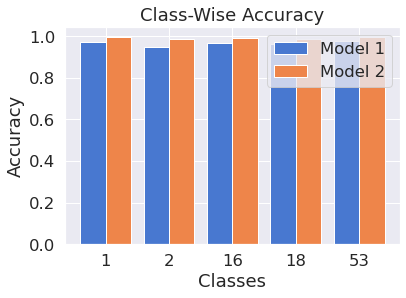

In [15]:
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, acc1_list, 0.4, label = 'Model 1')
plt.bar(X_axis + 0.2, acc2_list, 0.4, label = 'Model 2')
  
plt.xticks(X_axis, X)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Class-Wise Accuracy")
plt.legend()
plt.show()

In [16]:
cm1 = confusion_matrix(truth_label_1, pred_label_1, normalize='all')
# f1 = sns.heatmap(cm1, annot=True)
cm2 = confusion_matrix(truth_label_2, pred_label_2, normalize='all')
# f2 = sns.heatmap(cm2, annot=True)

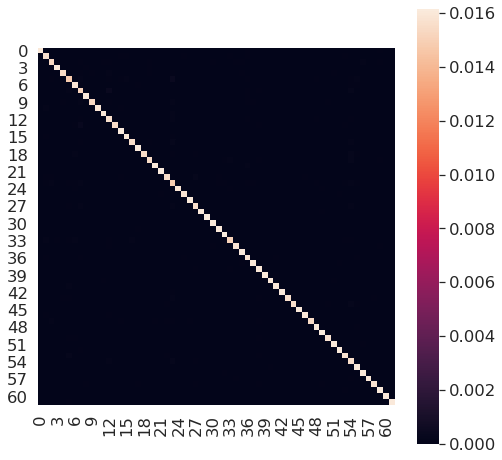

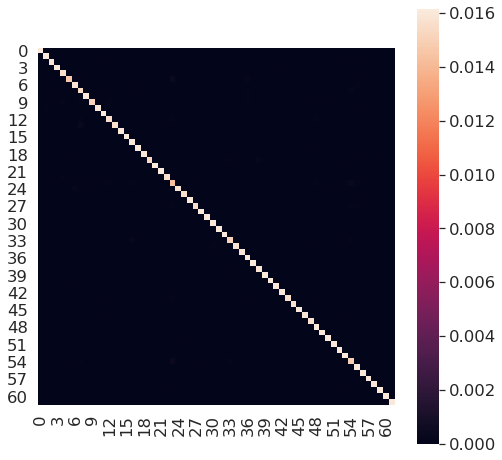

In [17]:
# with sns.axes_style("white"):
f1, ax1 = plt.subplots(figsize=(8, 8))
ax1 = sns.heatmap(cm1 ,vmax=np.max(cm1), square=True)
f2, ax2 = plt.subplots(figsize=(8, 8))
ax2 = sns.heatmap(cm2 ,vmax=np.max(cm2), square=True)

###  Visualization

In [18]:
def scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int64)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

#     for i in range(num_classes):

#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)

    return f, ax, sc, txts

def pca_visualize(pool, colors):
    time_start = time.time()

    pca = PCA(n_components=4)
    pca_result = pca.fit_transform(pool)

    print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

    pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

    pca_df['pca1'] = pca_result[:,0]
    pca_df['pca2'] = pca_result[:,1]
    pca_df['pca3'] = pca_result[:,2]
    pca_df['pca4'] = pca_result[:,3]

    print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

    top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
    
    scatter(top_two_comp.values,colors)
    
def tsne_visualize(pool, colors):
    RS = 123
    model_tsne = TSNE(random_state=RS).fit_transform(pool)
    # /np.max(model_tsne)
    scatter(model_tsne, colors)

In [19]:
viewed_samples = 5000 # number of points to be seen
pool1 = feature_list_1[:viewed_samples]
print(pool1.shape)
colors1 = truth_label_1[:viewed_samples]
print(len(colors1))
pool2 = feature_list_2[:viewed_samples]
print(pool2.shape)
colors2 = truth_label_2[:viewed_samples]
print(len(colors2))

(5000, 100)
5000
(5000, 100)
5000


PCA done! Time elapsed: 0.05296730995178223 seconds
Variance explained per principal component: [0.5297854  0.14459455 0.11164133 0.05920621]
PCA done! Time elapsed: 0.006676673889160156 seconds
Variance explained per principal component: [0.24986069 0.09049679 0.05116224 0.0482709 ]


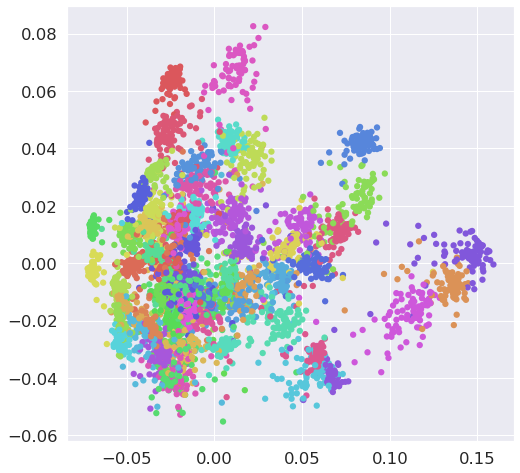

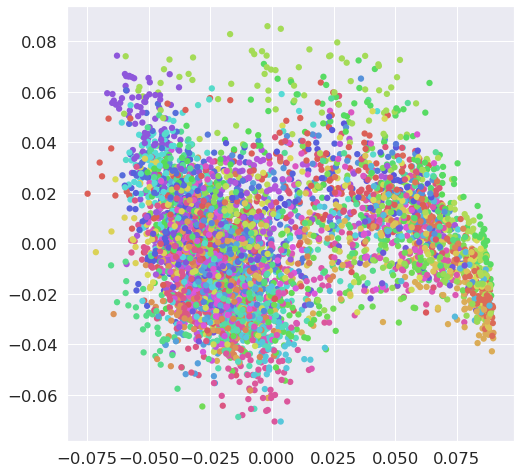

In [20]:
# sample run of pca
pca_visualize(pool1, colors1)
pca_visualize(pool2, colors2)

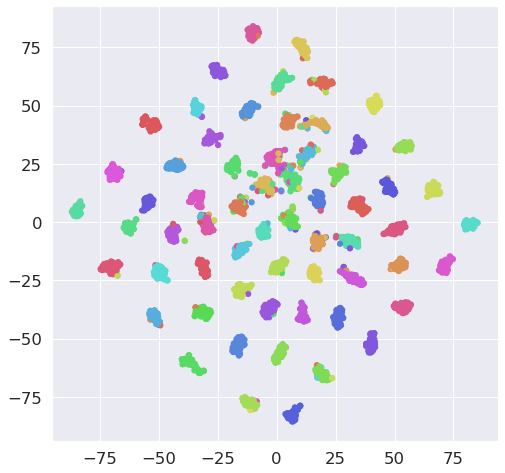

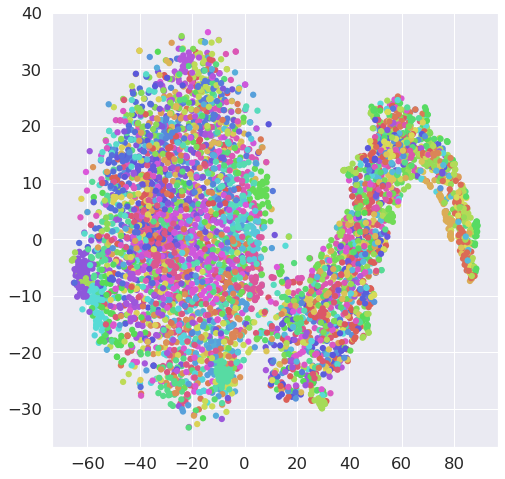

In [21]:
tsne_visualize(pool1, colors1)
tsne_visualize(pool2, colors2)